# Ingest polls → SQLite → EDA (Norway 2025)


### What this notebook does

- Connects to a local SQLite database of Norwegian polling data (`../data/processed/polls.sqlite`).
- If the DB is missing but a seed CSV exists, it creates the DB from `../data/raw/seed_polls.csv`.
- Loads polls into a pandas DataFrame and runs basic sanity checks.
- Plots simple time series (raw and rolling averages) for selected parties.
- Computes and plots a basic left vs right “block” view.
- Exports a tidy CSV snapshot for downstream analysis.


In [1]:
import os, sqlite3
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("pandas", pd.__version__)
print("numpy", np.__version__)


pandas 2.2.3
numpy 2.2.6


### Why these imports

- `pandas` for tabular data and I/O.
- `numpy` for simple numeric ops (e.g., sums with NaN handling).
- `matplotlib` for plotting.
- `sqlite3` to read/write the local SQLite database.

Printing library versions helps with reproducibility and debugging environment issues later.


In [2]:
ROOT = Path.cwd().resolve()
DATA_PROCESSED = (ROOT / "../data/processed").resolve()
DATA_RAW = (ROOT / "../data/raw").resolve()
DB_PATH = DATA_PROCESSED / "polls.sqlite"
SEED_CSV = DATA_RAW / "seed_polls.csv"

DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

# Seed DB hvis mangler
if not DB_PATH.exists() and SEED_CSV.exists():
    conn = sqlite3.connect(DB_PATH)
    df_seed = pd.read_csv(SEED_CSV)
    df_seed.to_sql("polls", conn, if_exists="replace", index=False)
    conn.commit(); conn.close()
    print("Opprettet DB fra seed:", DB_PATH)
else:
    print("Bruker DB:", DB_PATH, "| Seed finnes:", SEED_CSV.exists())


Bruker DB: /workspaces/Norway-2025-polls/data/processed/polls.sqlite | Seed finnes: True


### Configure paths and ensure the database exists

- Defines paths for processed data, raw data, and the SQLite DB.
- If `polls.sqlite` does not exist but `seed_polls.csv` does, we create the `polls` table from that CSV.
- This makes the notebook idempotent: you can run it on a clean environment and still get a working DB.


In [3]:
# Les inn
conn = sqlite3.connect(DB_PATH)
df = pd.read_sql("SELECT * FROM polls", conn)
conn.close()

df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.sort_values("date").reset_index(drop=True)

party_cols = [c for c in ["ap","h","frp","sp","sv","krf","v","mdg","r","p","dem"] if c in df.columns]
df = df[["pollster","date", *party_cols]]
df.head()


,pollster,date,ap,h,frp,sp,sv,krf,v,mdg,r
0,pollofpolls_avg,2025-01-31,19.0,21.7,24.4,6.2,8.1,3.4,4.5,3.3,5.4
1,pollofpolls_avg,2025-02-28,24.8,18.4,24.6,6.6,7.4,3.0,4.2,2.4,5.4
2,pollofpolls_avg,2025-03-31,28.1,18.8,22.7,4.9,7.2,3.1,4.3,2.7,4.6
3,pollofpolls_avg,2025-04-30,28.1,19.8,20.0,6.7,6.3,3.3,3.9,3.1,4.8
4,pollofpolls_avg,2025-05-31,28.5,18.7,20.6,5.7,7.0,3.6,4.1,2.7,5.3


### Load and tidy the polling data

- Reads the `polls` table from `polls.sqlite` into a DataFrame.
- Parses `date` into a proper datetime and sorts by time.
- Selects a standard column order: `pollster`, `date`, then party columns (if present).
- Using a consistent schema early prevents downstream plotting and modeling errors.


In [4]:
summary = {
    "rows": len(df),
    "date_min": df["date"].min(),
    "date_max": df["date"].max(),
    "parties_present": party_cols,
}
summary


{'rows': 20,
 'date_min': Timestamp('2025-01-31 00:00:00'),
 'date_max': Timestamp('2025-09-24 00:00:00'),
 'parties_present': ['ap', 'h', 'frp', 'sp', 'sv', 'krf', 'v', 'mdg', 'r']}

### Sanity summary

- Shows row count, min/max dates, and which party columns are present.
- This is a quick “does this look reasonable?” check before deeper analysis.


In [5]:
plausible = True
issues = []
for c in party_cols:
    if df[c].min() < 0 or df[c].max() > 50:
        plausible = False
        issues.append((c, float(df[c].min()), float(df[c].max())))
(plausible, issues[:5])


(True, [])

### Plausibility check for party percentages

- Flags any party columns with values outside a broad [0, 50] percent range.
- This catches basic data entry issues or parsing problems (e.g., percentages as 0–1 instead of 0–100).
- If you see issues here, fix the data before trusting any plots or models.


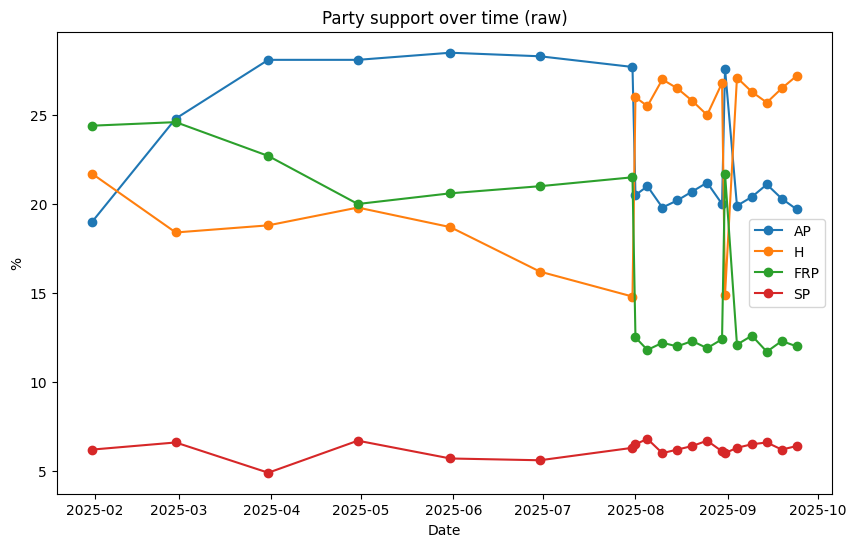

In [6]:
plt.figure(figsize=(10,6))
for p in ["ap","h","frp","sp"]:
    if p in party_cols:
        plt.plot(df["date"], df[p], marker="o", label=p.upper())
plt.legend(); plt.title("Party support over time (raw)"); plt.ylabel("%"); plt.xlabel("Date")
plt.show()


### Visualize raw polling trends

- Plots raw support over time for a few headline parties (AP, H, FRP, SP) if present.
- This gives a first visual sense of trends and variability across polls.
- Markers show individual polls; no smoothing is applied yet.


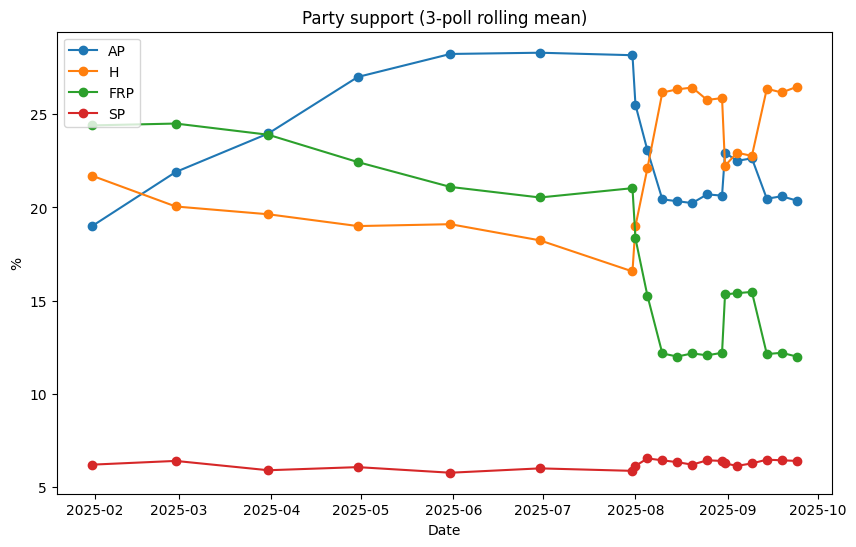

In [7]:
df_roll = df.copy()
for p in party_cols:
    df_roll[p] = df_roll[p].rolling(window=3, min_periods=1).mean()

plt.figure(figsize=(10,6))
for p in ["ap","h","frp","sp"]:
    if p in party_cols:
        plt.plot(df_roll["date"], df_roll[p], marker="o", label=p.upper())
plt.legend(); plt.title("Party support (3-poll rolling mean)"); plt.ylabel("%"); plt.xlabel("Date")
plt.show()


### Smooth the series with a rolling mean

- Computes a simple 3-poll rolling average for each party.
- The rolling mean reduces noise from individual polls and makes trend direction easier to see.
- Still keep the raw plot for transparency; this is just a complementary view.


In [8]:
left_block = {"ap","sv","sp","mdg","r"}
right_block = {"h","frp","krf","v"}

def block_sum(row, block):
    return float(np.nansum([row[p] for p in block if p in row.index]))

df_blocks = df[["pollster","date"]].copy()
df_blocks["left"] = df.apply(lambda r: block_sum(r, left_block), axis=1)
df_blocks["right"] = df.apply(lambda r: block_sum(r, right_block), axis=1)
df_blocks["other"] = 100 - (df_blocks["left"] + df_blocks["right"])
df_blocks.tail(3)


,pollster,date,left,right,other
17,Respons,2025-09-14,45.0,45.8,9.2
18,Kantar,2025-09-19,44.1,46.9,9.0
19,Ipsos,2025-09-24,43.9,47.3,8.8


### Construct left and right political blocks

- Defines two simple blocks:
  - Left: AP, SV, SP, MDG, R
  - Right: H, FRP, KrF, V
- Sums party support within each block per poll to estimate total block support.
- This is a very rough grouping; real coalition behavior can differ. We document assumptions here for transparency.


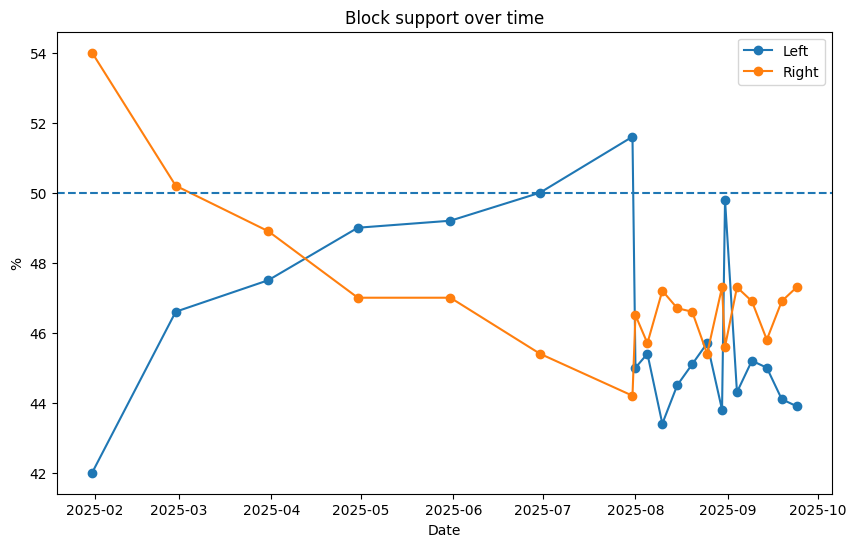

In [9]:
plt.figure(figsize=(10,6))
plt.plot(df_blocks["date"], df_blocks["left"], marker="o", label="Left")
plt.plot(df_blocks["date"], df_blocks["right"], marker="o", label="Right")
plt.axhline(50, linestyle="--")
plt.legend(); plt.title("Block support over time"); plt.ylabel("%"); plt.xlabel("Date")
plt.show()


### Compare blocks over time

- Plots left vs right block support as simple lines, with a horizontal 50% reference.
- This answers “who would likely secure a majority?” at a glance, under our block assumptions.
- Remember this is poll-level data, not seat projections; seat allocation would require an electoral formula.


In [10]:
OUT_CSV = (Path.cwd() / "../data/processed/polls_latest.csv").resolve()
df.to_csv(OUT_CSV, index=False)
OUT_CSV.as_posix()


'/workspaces/Norway-2025-polls/data/processed/polls_latest.csv'

### Export a tidy snapshot for downstream work

- Writes the current, cleaned DataFrame to `../data/processed/polls_latest.csv`.
- Useful for quickly feeding other notebooks, dashboards, or model pipelines without re-running ingestion.
- Keeps your workflow modular and reproducible.
